In [1]:
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import effective_sample_size, hpdi, print_summary
from numpyro.infer import NUTS, MCMC, Predictive, SVI, Trace_ELBO, init_to_value

from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoDiagonalNormal
from numpyro import sample, deterministic
numpyro.set_host_device_count(10)
from numpyro.distributions import constraints
from numpyro.diagnostics import effective_sample_size, print_summary

import warnings

import jax
import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
import os
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator)

from arviz.data.base import dict_to_dataset

from scipy.special import expit as logistic
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})

In [2]:
fname_price = "model_input_paper.csv"
fname_dollar = "model_input_dollar_paper.csv"
df1 = pd.read_csv(fname_price)
df2 = pd.read_csv(fname_dollar)
print(len(df1))
print(len(df2))

4164398
187727


In [3]:
profile_x_idx, p_x = pd.factorize(df1["profile_label_x"])
profile_y_idx, p_y = pd.factorize(df1["profile_label_y"])


s_x = pd.Index(np.array(["Third Party 9","First Party 1","First Party 6","First Party 7 ","Third Party 10","Third Party 3","Third Party 15","Third Party 8",
"Third Party 14","First Party 9","First Party 3","Third Party 23","Third Party 18","Third Party 11","Third Party 1","Third Party 20",
"Third Party 22","Third Party 13","Third Party 7","Third Party 19","First Party 5","Third Party 6","Third Party 25","Third Party 2",
"Third Party 16","First Party 8","Third Party 24","First Party 4","Third Party 21","Third Party 4","First Party 2","Third Party 5",
"Third Party 12","Third Party 17"]))

s_y = pd.Index(np.array(["Third Party 9","First Party 1","First Party 6","First Party 7 ","Third Party 10","Third Party 3","Third Party 15","Third Party 8",
"Third Party 14","First Party 9","First Party 3","Third Party 23","Third Party 18","Third Party 11","Third Party 1","Third Party 20",
"Third Party 22","Third Party 13","Third Party 7","Third Party 19","First Party 5","Third Party 6","Third Party 25","Third Party 2",
"Third Party 16","First Party 8","Third Party 24","First Party 4","Third Party 21","Third Party 4","First Party 2","Third Party 5",
"Third Party 12","Third Party 17"]))


price_diff = jnp.asarray(df1.price_diff.values)

seller_x = jnp.asarray(df1.seller_idx)
seller_y = jnp.asarray(df1.seller_idx)

profile_x = jnp.asarray(profile_x_idx)
profile_y = jnp.asarray(profile_y_idx)

### We implement the follwing model as described in the paper

\begin{align}
    y_{i,j|k}&\sim \mathrm{Bin}(1, p_{i,j|k}) ------------ \text{likelihood function to see a worse price}\\
    \mathrm{Logit}(p_{i,j|k}) &= \bar{p} + (\beta_i-\beta_j)+  (\delta_{k,i}-\delta_{k,j}) \label{eq:link} ---------\text{logit prob of observing worse price}\\
    \beta_i &\sim \mathrm{N}(\bar{\beta},\beta_\sigma)  \label{eq:beta} -------------> \text{prob of profile $i$ seeing worse price}\\
    \bar{\beta} &\sim \mathrm{N}(0.0,1.0)  ------------->  \text{$\beta_i$ mean}\\
    \beta_\sigma &\sim \mathrm{Exp}(1.0)  ------------->  \text{$\beta_i$ standard deviation}\\
    \delta_{k,i} &\sim \mathrm{N}(0.0,0.25)  ------------->   \text{prob of profile $i$ seeing worse price from seller $k$}\\
    \bar{p} &\sim \mathrm{N}(-3.0,1.0) \ ------------->  \text{base prob of seeing worse price}
\end{align}


In [4]:
def model0(pref, seller_x, profile_x, seller_y, profile_y):
    # making the model about differences conditioned on the same seller
    Nprofiles_x = len(np.unique(profile_x))
    Nprofiles_y = len(np.unique(profile_y))

    Nsellers_x = len(np.unique(seller_x))
    Nsellers_y = len(np.unique(seller_y))

    #Nroutes = len(np.unique(route))

    p_bar = sample("p_bar", dist.Normal(-3, 1))

    β_σ = sample("β_σ", dist.Exponential(1.0))
    β_var = sample("β_var", dist.Normal(0.0, 1.0).expand([Nprofiles_x]))
    β = β_var * β_σ # regularizing prior will cancel when we take the difference
    δ = sample("δ", dist.Normal(0, 0.25).expand([Nsellers_x, Nprofiles_x]))
    logit_p = p_bar + (β[profile_x] - β[profile_y]) + (δ[seller_x, profile_x] - δ[seller_y, profile_y])
    sample("preference", dist.Binomial(logits=logit_p), obs=pref)


## Use an autoguide from numpyro and run the SVI

In [5]:
autoGuide = AutoDiagonalNormal(model0)
data_dict_svi = {
    "seller_x" : seller_x,
    "profile_x" : profile_x,
    "seller_y" : seller_y,
    "profile_y" : profile_y,
}
svi = SVI(
    model0,
    autoGuide,
    optim.Adam(5e-4),
    Trace_ELBO(),
    **data_dict_svi
)
num_steps = 15000
svi_result = svi.run(random.PRNGKey(0), num_steps, price_diff)
params = svi_result.params

# Run predictive and get use that for the trace
predictive = Predictive(autoGuide, params=params, num_samples=10000)
samples = predictive(random.PRNGKey(1), price_diff, **data_dict_svi)

100%|██████████| 15000/15000 [45:23<00:00,  5.51it/s, init loss: 14676065.0000, avg. loss [14251-15000]: 604343.1250]


## Ensure Convergence

Text(0, 0.5, 'Loss (millions)')

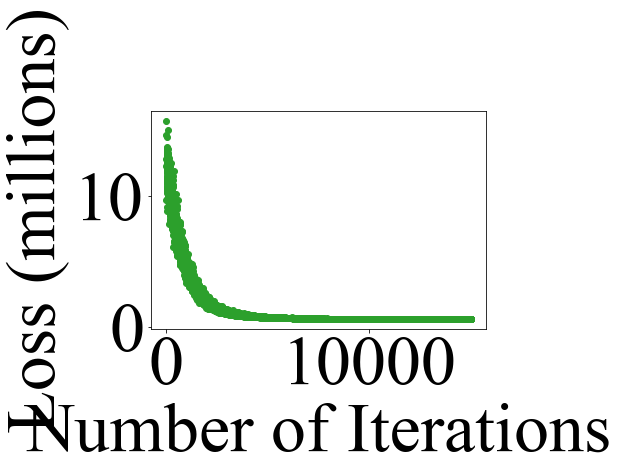

In [6]:
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 70})
plt.rcParams.update({'font.weight' : 'normal'})
plt.rcParams["font.family"] = "Times New Roman"

fig, ax=plt.subplots()

ax.scatter(np.arange(0, num_steps), svi_result.losses/1000000, c='#2ca02c')

plt.xlabel('Number of Iterations')
plt.ylabel('Loss (millions)') 
#plt.savefig('elbo3.pdf',  bbox_inches='tight', pad_inches = 0)

### Populate an arviz object

In [7]:
samples.pop('_auto_latent', None)
for elem in samples:
    samples[elem] = samples[elem][np.newaxis, :]

In [8]:
dims = {
    'β_var': ['profiles'],
    'δ': ['sellers', 'profiles']
}
coords = {'profiles' : p_x, 'sellers' : s_x}
f_data = dict_to_dataset(samples, coords = coords, dims= dims)
f_data = az.InferenceData(posterior = f_data)

In [9]:
az.to_netcdf(data=f_data, filename='prob_model3.trace')

'prob_model3.trace'

# Setup for the Price Difference Model

In [10]:
profile_x_idx, p_x = pd.factorize(df2["profile_label_x"])
profile_y_idx, p_y = pd.factorize(df2["profile_label_y"])


s_x = pd.Index(np.array(["First Party 1","First Party 7 ","Third Party 10","Third Party 3","Third Party 8",
"Third Party 14","First Party 3","Third Party 23","Third Party 18","Third Party 11","Third Party 1",
"Third Party 22", "Third Party 13","Third Party 7","Third Party 19","First Party 5","Third Party 6","Third Party 25","Third Party 2",
"Third Party 16", "First Party 8","Third Party 24","Third Party 21","Third Party 4","First Party 2","Third Party 5",
"Third Party 12"  ]))

s_y = s_x

price_diff = jnp.asarray(df2.price_diff.values)

seller_x = jnp.asarray(df2.seller_idx)
seller_y = jnp.asarray(df2.seller_idx)

profile_x = jnp.asarray(profile_x_idx)
profile_y = jnp.asarray(profile_y_idx)

## The Price Difference Model - note the main difference the predicted distribution is normal vs binomial


\begin{align}
    y_{i,j|k}&\sim \text{N}(\mu_{i,j|k}, \sigma_{i,j|k})\label{eq:norm} \\ 
    \mu_{i,j|k} &= \bar{p} + (\beta_i-\beta_j)+  (\delta_{k,i}-\delta_{k,j}) \label{eq:mu}\\
    \sigma_{i,j|k} &\sim \text{N}(0.0,1.0) \\
    \beta_i &\sim \text{N}(\bar{\beta},\beta_\sigma)\label{eq:beta2} \\ %& \text{prob of profile $i$ seeing worse price}\\
    \bar{\beta} &\sim \text{N}(0.0,1.0) \\ %& \text{$\beta_i$ mean}\\
    \beta_\sigma &\sim \text{Exp}(1.0) \\ %& \text{$\beta_i$ standard deviation}\\
    \delta_{k,i} &\sim \text{N}(0.0,1.0)\label{eq:delta2} \\ %& \text{prob of profile $i$ seeing worse price from seller $k$}\\
    \bar{p} &\sim \text{N}(5.0,30.0)\label{eq:pbar2} %& \text{base prob of seeing worse price}
\end{align}


In [11]:
def model0_dollar(price_diff, seller_x, profile_x, seller_y, profile_y):
    # making the model about differences conditioned on the same seller
    Nprofiles_x = len(np.unique(profile_x))
    Nprofiles_y = len(np.unique(profile_y))

    Nsellers_x = len(np.unique(seller_x))
    Nsellers_y = len(np.unique(seller_y))

    p_bar = sample("p_bar", dist.Normal(5.0, 30.0))

    β_σ = sample("β_σ", dist.Exponential(1.0))
    β_var = sample("β_var", dist.Normal(0.0, 1.0).expand([Nprofiles_x]))
    β = β_var * β_σ # regularizing prior will cancel when we take the difference

    δ = sample("δ", dist.Normal(0, 1.0).expand([Nsellers_x, Nprofiles_x]))

    mu = p_bar + (β[profile_x] - β[profile_y]) + (δ[seller_x, profile_x] - δ[seller_y, profile_y])

    sigma = sample("sigma", dist.Exponential(1.0))

    sample("price_difference", dist.Normal(mu, sigma), obs=price_diff)


In [12]:
autoGuide = AutoDiagonalNormal(model0_dollar)
data_dict_svi = {
    "seller_x" : seller_x,
    "profile_x" : profile_x,
    "seller_y" : seller_y,
    "profile_y" : profile_y,
}
svi = SVI(
    model0_dollar,
    autoGuide,
    optim.Adam(5e-4),
    Trace_ELBO(),
    **data_dict_svi
)
num_steps = 15000
svi_result = svi.run(random.PRNGKey(0), num_steps, price_diff)
params = svi_result.params

# Run predictive and get use that for the trace
predictive = Predictive(autoGuide, params=params, num_samples=10000)
samples = predictive(random.PRNGKey(1), price_diff, **data_dict_svi)

100%|██████████| 15000/15000 [02:00<00:00, 124.84it/s, init loss: 6834969.0000, avg. loss [14251-15000]: 964113.4375]


### Also populate Arviz object

In [13]:
samples.pop('_auto_latent', None)
for elem in samples:
    samples[elem] = samples[elem][np.newaxis, :]

In [14]:
dims = {
    'β_var': ['profiles'],
    'δ': ['sellers', 'profiles']
}
coords = {'profiles' : p_x, 'sellers' : s_x}
f_datap = dict_to_dataset(samples, coords = coords, dims= dims)
f_datap = az.InferenceData(posterior = f_datap)

### Help to match it to the right set

In [15]:
conversion = np.array(["First Party 1","First Party 7 ","Third Party 10","Third Party 3","Third Party 8",
"Third Party 14","First Party 3","Third Party 23","Third Party 18","Third Party 11","Third Party 1",
"Third Party 22", "Third Party 13","Third Party 7","Third Party 19","First Party 5","Third Party 6","Third Party 25","Third Party 2",
"Third Party 16", "First Party 8","Third Party 24","Third Party 21","Third Party 4","First Party 2","Third Party 5",
"Third Party 12"  ])
profile_conversion = np.array(['Control', 'F_B', 'M_B', 'Y_B', 'S_A', 'M_A',
       'S_B', 'F_A', 'Y_A'])

f_datap.posterior['sellers'] = conversion
f_datap.posterior['profiles'] = profile_conversion

In [16]:
az.to_netcdf(data=f_datap, filename='dollar_model3.trace')

'dollar_model3.trace'